# 4. Assignment (Linear and logistic regression)

## 4.1 Objectives

The objectives of this assignment are:

1. To learn to use linear regression for predicting continuously varying target variables
2. To learn to use logistic regression for binary classification
3. To learn to estimate the relative importance of input features

## 4.2 Data understanding

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
real_estate_valuation = fetch_ucirepo(id=477) 
  
# data (as pandas dataframes) 
X = real_estate_valuation.data.features 
y = real_estate_valuation.data.targets 
  
# metadata 
print(real_estate_valuation.metadata) 
  
# variable information 
print(real_estate_valuation.variables) 

df_x = pd.DataFrame(X)
df_y = pd.DataFrame(y)
df_combined = pd.concat([df_x, df_y], axis=1)


{'uci_id': 477, 'name': 'Real Estate Valuation', 'repository_url': 'https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set', 'data_url': 'https://archive.ics.uci.edu/static/public/477/data.csv', 'abstract': 'The real estate valuation is a regression problem. The market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan. ', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 414, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Y house price of unit area'], 'index_col': ['No'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C5J30W', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'Building real estate valuation models with comparative approach through case-based reasoning', 'authors': 'I. Yeh, Tzu-Kuang Hsu', 'published_

In [3]:
df_combined

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [4]:
df_combined.describe(include='all')

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [5]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            414 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


The dataset contains 414 records and 8 columns.There are no data with missing values.  
Structure of the data:

- `No`: Record number.
- `X1 transaction date`: Transaction date (in year and fraction of a month format).
- `2 house age: Age of the house in years`.
- `X3 distance to the nearest MRT station`: Distance to the nearest MRT station (in meters).
- `X4 number of convenience stores`: Number of stores in the neighborhood.
- `X5 latitude`: Latitude of the property location.
- `X6 longitude`: Longitude of the property location.
- `Y house price of unit area` : The price of the property per unit area (target variable).

## 4.3 Data preparation

First, let's see what the data set looks like

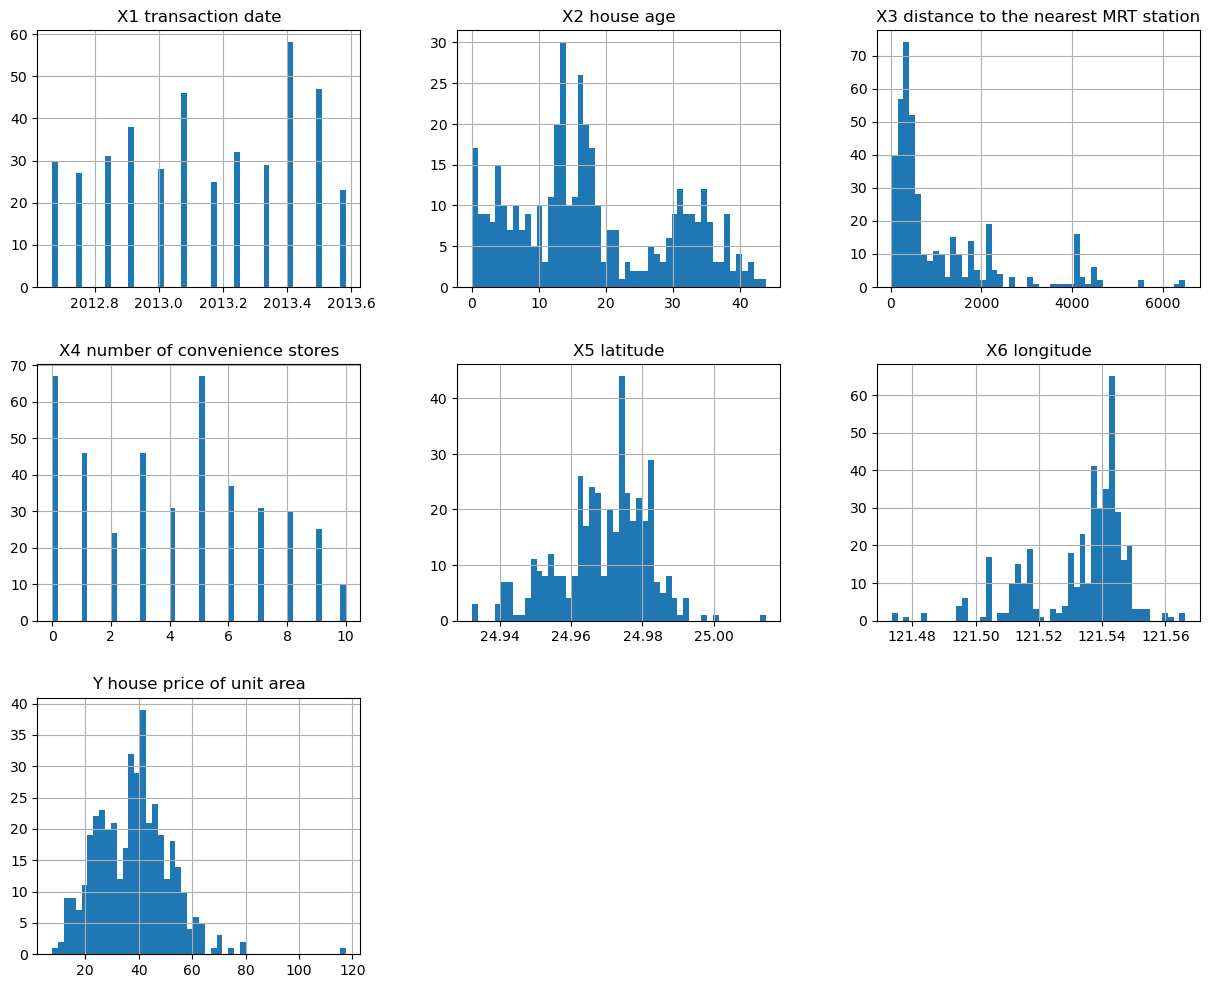

In [6]:
df_combined.hist(bins=50, figsize=[15,12]);

Проверим данные на наличие корреляции

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Рассчитываем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                                  Feature           VIF
0                     X1 transaction date  4.253389e+07
1                            X2 house age  3.471392e+00
2  X3 distance to the nearest MRT station  4.261358e+00
3         X4 number of convenience stores  4.748152e+00
4                             X5 latitude  6.178301e+06
5                            X6 longitude  4.198817e+07


Один из признаков имеет высокий коэффициент мультиколлинеарности. Так проект учебный, то мы не станем его удалять, но в реальной жизни коэффициенты мультиколлинеарности следует учитывать и оценивать его влияние на модель.

Линейная регрессия чувствительна к масштабу признаков, особенно если диапазоны значений отличаются значительно. Например, расстояние до станции метро (в метрах) и количество магазинов имеют разные масштабы. Рекомендуется нормализовать или стандартизировать признаки, чтобы улучшить сходимость модели. В этом случае мы будем использовать стандартизацию, так как она менее чувствительна к выбросам.

Но чтобы стандартизировать данные, нам нужно сначала разделить данные на обучающий и валидационный наборы. А перед этим выделить тестовую часть для финальной оценки эффективности модели.

In [8]:
from sklearn.model_selection import train_test_split
# Dataset separation
# 80% of the data will be used for training and 20% for testing
work_data, test_data, work_targets, test_targets = train_test_split(df_x, df_y, test_size=0.2)

# Then we will divide the work data into training and validation data
train_data, val_data, train_targets, val_targets = train_test_split(work_data, work_targets, test_size=0.2)

Далее стандартизуем полученные наборы данных

In [9]:
from sklearn.preprocessing import StandardScaler
# Standardization of data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.fit_transform(val_data)
test_data = scaler.fit_transform(test_data)
work_data = scaler.fit_transform(work_data)

Так как мы так же будем строить модель логической регрессии, то преобразуем целевую переменную в бинарный формат.

In [10]:
median_price = train_targets.median()
train_targets_binary = (train_targets > median_price).astype(int)
val_targets_binary = (val_targets > median_price).astype(int)
test_targets_binary = (test_targets > median_price).astype(int)
work_targets_binary = (work_targets > median_price).astype(int)

Посмотрим на данные после преобразований

## 4.4 Modeling

### 4.4.1 Linear regression

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
# Create a model
model_linear = LinearRegression(fit_intercept = True)
model_linear.fit(train_data, train_targets)

# Predictions
predictions = model_linear.predict(val_data)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate the error metrics
mse = mean_squared_error(val_targets, predictions)
mae = mean_absolute_error(val_targets, predictions)
R2 = r2_score(val_targets, predictions)

In [13]:
print("b =", model_linear.intercept_)
print("W =", model_linear.coef_)
print("R^2 =", R2)
print("MSE =", mse)
print("MAE =", mae)

b = [37.65871212]
W = [[ 1.39416302 -2.95104929 -4.22178236  3.53472191  2.91218407  0.89196724]]
R^2 = 0.44087909844184814
MSE = 153.91773626264794
MAE = 7.1260446386873095


### 4.4.2 Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import column_or_1d

# Transform the target variable to 1d array
work_targets_binary = column_or_1d(work_targets_binary, warn=True)

# Create a model
model_reg = LogisticRegression(solver='lbfgs').fit(work_data, work_targets_binary)

print("Coefficients: ",model_reg.coef_)
print("Intercept: ", model_reg.intercept_)

Coefficients:  [[ 0.29392973 -0.72287358 -1.99783355  0.57843036  0.97032908  0.21198799]]
Intercept:  [-0.71119225]


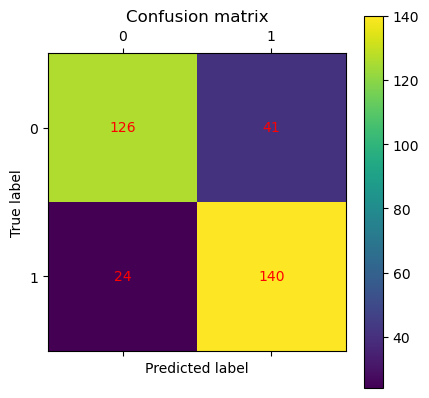

In [22]:
# cross-validation
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(estimator=model_reg, X=work_data, y=work_targets_binary, cv=10)

# confusion matrix
cm = confusion_matrix(work_targets_binary, y_pred)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [16]:
print(classification_report(work_targets_binary, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       167
           1       0.77      0.85      0.81       164

    accuracy                           0.80       331
   macro avg       0.81      0.80      0.80       331
weighted avg       0.81      0.80      0.80       331



The model seems to predict the outcome quite well, with an accuracy of 0.83. Contransting this to the performance of a random classifier, which would have an accuracy of 0.5, the model seems to be doing a decent job.

## 4.5 Evaluation

### 4.5.1 Linear regression

Оценим точность модели линейной регрессии на тестовом наборе данных

In [17]:
# model_linear.fit(work_data, work_targets) ???
predictions = model_linear.predict(test_data)

In [18]:
# Calculate the error metrics
mse = mean_squared_error(test_targets, predictions)
mae = mean_absolute_error(test_targets, predictions)
R2 = r2_score(test_targets, predictions)

In [19]:
print("b =", model_linear.intercept_)
print("W =", model_linear.coef_)
print("R^2 =", R2)
print("MSE =", mse)
print("MAE =", mae)

b = [37.65871212]
W = [[ 1.39416302 -2.95104929 -4.22178236  3.53472191  2.91218407  0.89196724]]
R^2 = 0.7506766844464435
MSE = 38.96475588351665
MAE = 5.1825349100794345


### 4.5.2 Logistic regression

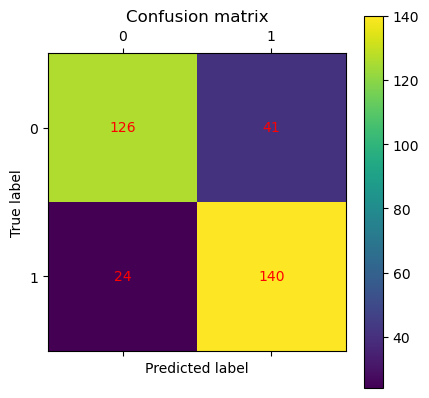

In [25]:
# Прогнозируем на тестовых данных
y_test_pred = model_reg.predict(test_data)

# Confusion matrix
cm_test = confusion_matrix(test_targets_binary, y_test_pred)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [27]:
# Отчет по классификации (precision, recall, F1-score)
print("Отчет по классификации на тестовых данных:")
print(classification_report(test_targets_binary, y_test_pred))

Отчет по классификации на тестовых данных:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        40
           1       0.85      0.91      0.88        43

    accuracy                           0.87        83
   macro avg       0.87      0.87      0.87        83
weighted avg       0.87      0.87      0.87        83



In [31]:
# interactive prediction

features=['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']

Xi = pd.DataFrame(columns=features)

# read input data
for f in features:
    val = input(f"Enter value for feature: {f}")
    Xi[f] = [float(val)]

# get probability estimate
Xi = pd.DataFrame(scaler.transform(Xi), columns=Xi.columns)
p = model_reg.predict_proba(Xi)[:,1]

# output
print("Probability that house price is lower: %0.2f" % p[0]);

Probability that house price is lower: 0.99


C:\Users\vdis0\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


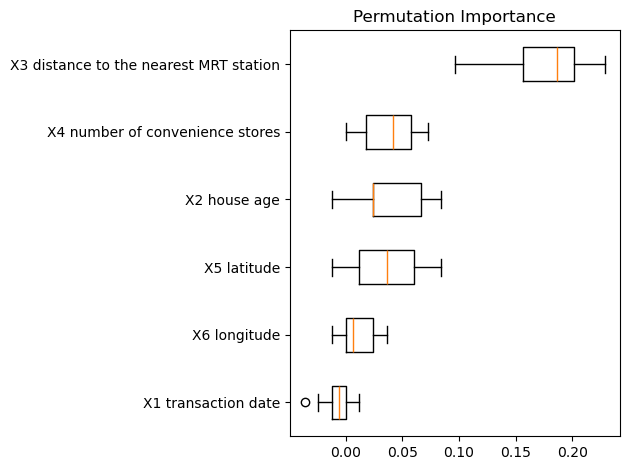

In [32]:
# feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(model_reg, test_data, test_targets_binary, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

## 4.6 Deployment